In [1]:
from Dataset.PAFDataset import TFDataset as DataGenerator
from utils.config import process_config
from matplotlib import pyplot as plt
import tensorflow as tf

import argparse
import numpy as np

tf.executing_eagerly()
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
config = process_config('config/paf_configuration.json')
train_data_generator = DataGenerator(config, 'train')

dataset = iter(train_data_generator())
x,y = next(dataset)

print(y[1].shape)
print(y[1][0])

(32, 240, 240, 2)
tf.Tensor(
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 ...

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]], shape=(240, 240, 2), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


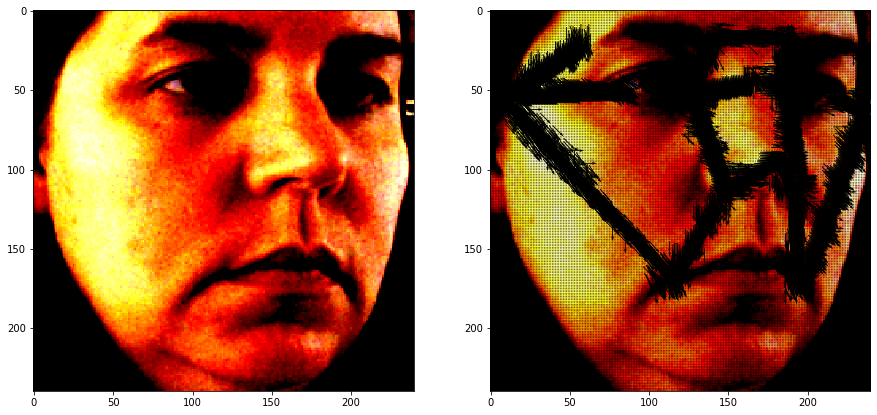

In [6]:
pid = 2
fig, axes = plt.subplots(1,2,figsize=(15,15))
axes[0].imshow(x[pid])
paf = y[1][pid]
paf = tf.transpose(paf, (2,0,1))
xi = np.arange(240)
yi = np.arange(240)
axes[1].imshow(x[pid])
axes[1].quiver(xi, yi, np.transpose(paf[0]), -np.transpose(paf[1]), scale_units='xy',scale=0.1)


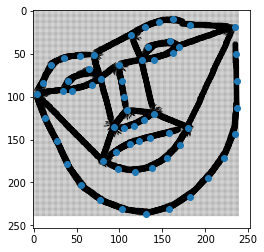

In [4]:
paf = y[1][pid] # 240, 240, 2
paf = tf.transpose(paf, (2,0,1))
img = np.zeros([100,100,3],dtype=np.uint8)
img.fill(255)
plt.imshow(img)
xi = np.arange(240)
yi = np.arange(240)
plt.quiver(xi, yi, np.transpose(paf[0]), -np.transpose(paf[1]), scale_units='xy',scale=0.1)
plt.scatter(xl, yl)



In [ ]:
print(y[2][1][239][239])